In [5]:
%load_ext autoreload
%autoreload 2
%cd '/home/xingyu/Projects/dynamic_abstraction'
%pwd
%matplotlib inline

import sys
sys.path.insert(0, "/home/xingyu/Projects/dynamic_abstraction/PointFlow")
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/xingyu/Projects/dynamic_abstraction


In [81]:
smp_path = 'data/PointFlow/checkpoints/data/PointFlow/gen/multidataset/airplane_out_smp.npy'
ref_path = 'data/PointFlow/checkpoints/data/PointFlow/gen/multidataset/airplane_out_ref.npy'
smp_pc = np.load(smp_path)
ref_pc = np.load(ref_path)
print(smp_pc.shape, ref_pc.shape)

(640, 2048, 3) (640, 2048, 3)


In [42]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(smp_pc[0])
o3d.visualization.draw_geometries([pcd])

In [82]:
from PointFlow.utils import visualize_saved_pc
import imageio
N = len(smp_pc)
results = []
for idx in range(0, N, N // 10):
    # res = visualize_saved_pc(smp_pc[idx],  ref_pc[idx], idx, 'dynabs')
    res = visualize_saved_pc(smp_pc[idx],  ref_pc[idx], idx, 0.2)
    results.append(res)
res = np.concatenate(results, axis=2).transpose(1, 2, 0)
imageio.imwrite('visualize.png', res)

In [23]:
from core.data_utils.pointcloud_dataset import PointFlowDataset
from copy import deepcopy
from PointFlow.utils import visualize_saved_pc
from PointFlow.args import get_parser

parser = get_parser()
args =  parser.parse_args("")
args.debug = False
args.data_dirs = ['./datasets/0323_multicut_train/', './datasets/0323_multimerge_train/']
args.sample_size = args.tr_max_sample_points
args.seed = 0
args.split = 'valid'
dataset = PointFlowDataset(args)

Adding path from: ./datasets/0323_multicut_train/
Adding path from: ./datasets/0323_multimerge_train/
Total: 3200, Train: 2560. Validation: 640
Current split: valid


Loading dataset: 100%|██████████| 640/640 [00:35<00:00, 18.26it/s]


dict_keys(['idx', 'train_points', 'test_points', 'mean', 'std', 'cate_idx', 'sid', 'mid'])
[[-9.2602277e-06 -1.6791455e-07 -6.0154889e-06]] [[0.03210528]]
torch.Size([2048, 3])


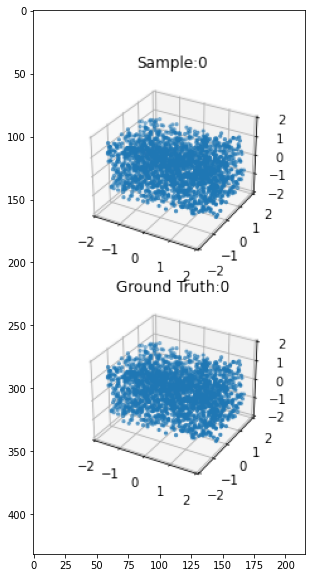

dict_keys(['idx', 'train_points', 'test_points', 'mean', 'std', 'cate_idx', 'sid', 'mid'])
[[-9.2602277e-06 -1.6791455e-07 -6.0154889e-06]] [[0.03210528]]
torch.Size([2048, 3])


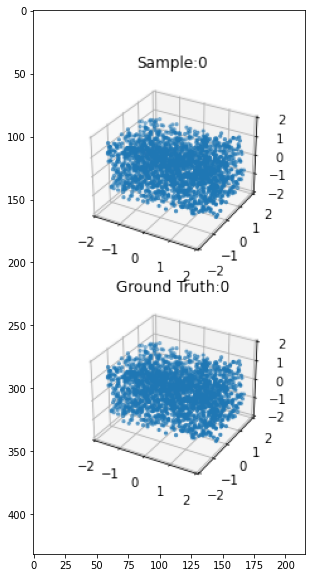

In [24]:
%matplotlib inline
data = dataset[-1]
print(data.keys())
print(data['mean'], data['std'])
pc = data['train_points']
print(pc.shape)
plt.figure(figsize=(10, 10))
res = visualize_saved_pc(pc,  pc, 0, 2)
plt.imshow(res.transpose(1,2,0))
plt.show()

In [53]:
from PointFlow.models.networks import PointFlow
from PointFlow.utils import save
import torch
args.dims = '512-512-512'
args.latent_dims = '256-256'
args.use_latent_flow = True
model = PointFlow(args)
model = model.cuda()

def _transform_(m):
    return torch.nn.DataParallel(m)

model.multi_gpu_wrapper(_transform_)

# resume_checkpoint = 'data/PointFlow/checkpoints/data/PointFlow/gen/multidataset/checkpoint-349.pt'
resume_checkpoint = 'checkpoints/multidataset_resume/checkpoint-599.pt'

checkpoint = torch.load(resume_checkpoint)
if 'model' in checkpoint:
    checkpoint = checkpoint['model']
    checkpoint['point_cnf.module.chain.1.sqrt_end_time'] = torch.ones(1) * 0.707
    checkpoint['latent_cnf.module.chain.1.sqrt_end_time'] = torch.ones(1)  * 0.707
model.load_state_dict(checkpoint, strict=True)
model.eval()
for key in model.state_dict().keys():
    print(key)

Number of trainable parameters of Point CNF: 927513
Number of trainable parameters of Latent CNF: 134145
encoder.module.conv1.weight
encoder.module.conv1.bias
encoder.module.conv2.weight
encoder.module.conv2.bias
encoder.module.conv3.weight
encoder.module.conv3.bias
encoder.module.conv4.weight
encoder.module.conv4.bias
encoder.module.bn1.weight
encoder.module.bn1.bias
encoder.module.bn1.running_mean
encoder.module.bn1.running_var
encoder.module.bn1.num_batches_tracked
encoder.module.bn2.weight
encoder.module.bn2.bias
encoder.module.bn2.running_mean
encoder.module.bn2.running_var
encoder.module.bn2.num_batches_tracked
encoder.module.bn3.weight
encoder.module.bn3.bias
encoder.module.bn3.running_mean
encoder.module.bn3.running_var
encoder.module.bn3.num_batches_tracked
encoder.module.bn4.weight
encoder.module.bn4.bias
encoder.module.bn4.running_mean
encoder.module.bn4.running_var
encoder.module.bn4.num_batches_tracked
encoder.module.fc1_m.weight
encoder.module.fc1_m.bias
encoder.module.fc

tensor([[ 3.2168e-06, -9.4576e-07,  3.4692e-07],
        [-3.9972e-06,  2.2433e-06, -1.8319e-06],
        [-4.7684e-06, -7.3283e-08,  4.6566e-07],
        [-6.4904e-06, -2.8743e-07, -7.3714e-07],
        [-5.4152e-06,  2.7334e-07, -2.3562e-07],
        [ 2.3413e-06, -1.7131e-07,  6.5174e-06],
        [ 5.8440e-07,  6.1467e-08,  1.1115e-05],
        [ 6.2562e-06,  8.4285e-08, -8.9873e-08],
        [ 2.5904e-06,  5.1688e-08,  4.3306e-06],
        [-1.9027e-06,  3.7951e-08,  8.6394e-06]])


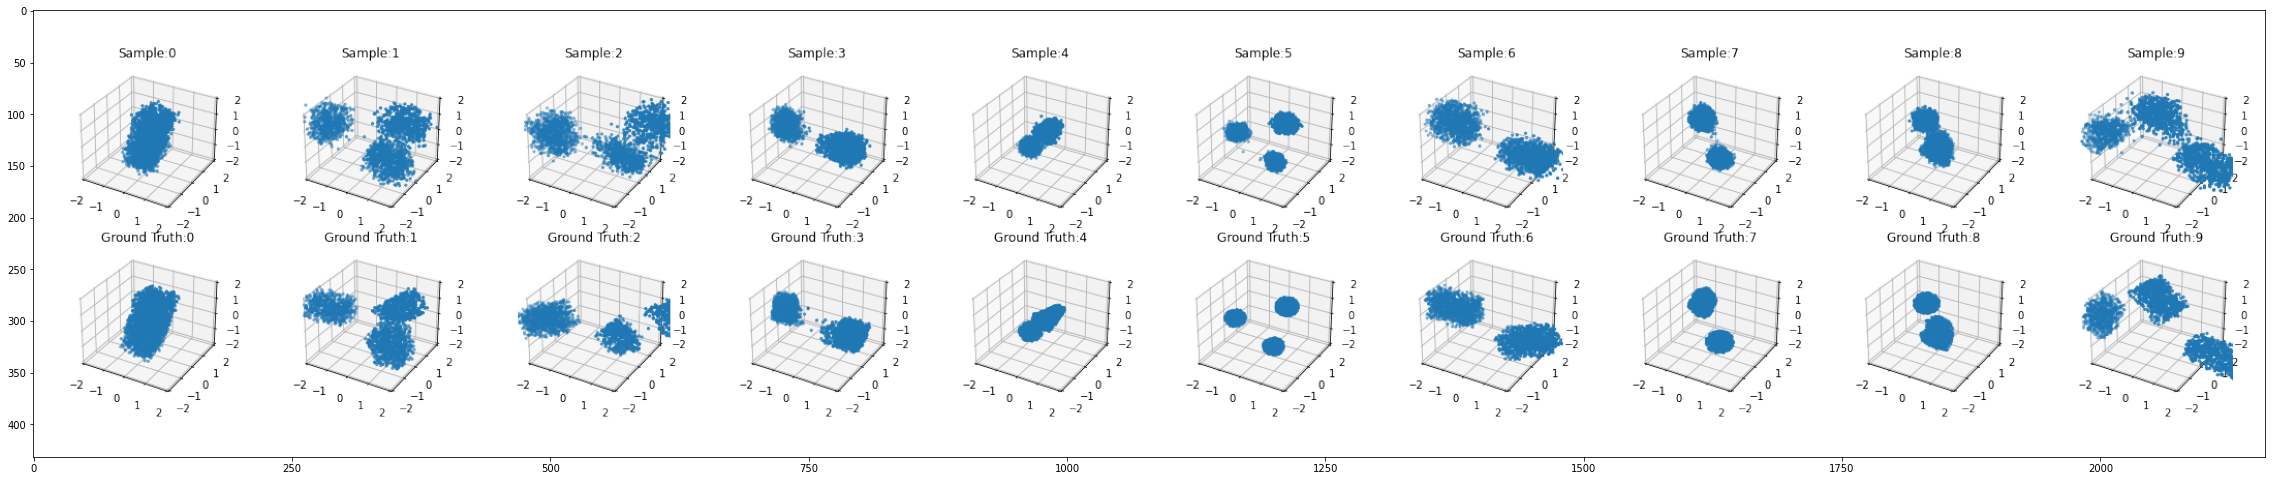

In [54]:
K = 10
# data = dataset[60:60+K]
data = dataset[10:10+K]
%matplotlib inline
model.eval()
with torch.no_grad():
    idx_b, tr_pc, te_pc = data['idx'], data['train_points'], data['test_points']
    print(te_pc.mean(axis=1))
    te_pc = te_pc.cuda() if args.gpu is None else te_pc.cuda(args.gpu)
    tr_pc = tr_pc.cuda() if args.gpu is None else tr_pc.cuda(args.gpu)
    B, N = te_pc.size(0), te_pc.size(1)
    out_pc = model.reconstruct(tr_pc, num_points=N)
    # m, s = data['mean'].float(), data['std'].float()
    # m = m.cuda() if args.gpu is None else m.cuda(args.gpu)
    # s = s.cuda() if args.gpu is None else s.cuda(args.gpu)
    results = []
    plt.figure(figsize=(40, 40))
    for idx in range(K):
        res = visualize_saved_pc(out_pc[idx].detach().cpu().numpy(), tr_pc[idx].detach().cpu().numpy(), idx, 2)
        results.append(res.transpose(1,2,0))
    results = np.hstack(results)
    plt.imshow(results)
    plt.show()
    # out_pc = out_pc * s + m
    # te_pc = te_pc * s + m
